In [66]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random



In [67]:
with open('final_info_05_meter.pickle', 'rb') as handle:
    results_05_meter = pickle.load(handle)

with open('final_info_1_meter.pickle', 'rb') as handle:
    results_1_meter = pickle.load(handle)
    
with open('final_info_15_meter.pickle', 'rb') as handle:
    results_15_meter = pickle.load(handle)
    
with open('final_info_2_meter.pickle', 'rb') as handle:
    results_2_meter = pickle.load(handle)

with open('room_info.pickle', 'rb') as handle:
    room_info = pickle.load(handle)
    
conversion_pixel_ft = (1235-862)/20

Text(0.5, 1.0, 'Max Unvax Seats vs. Seating Plan')

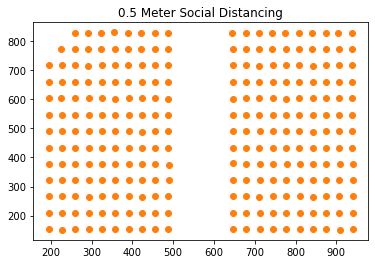

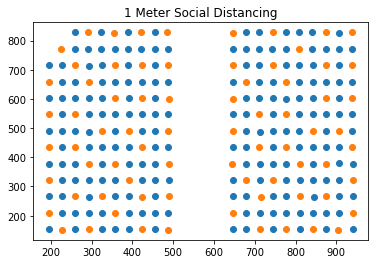

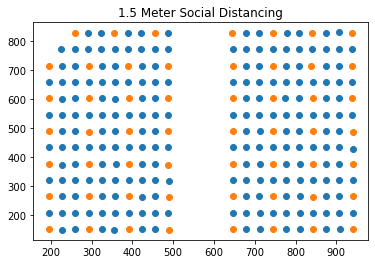

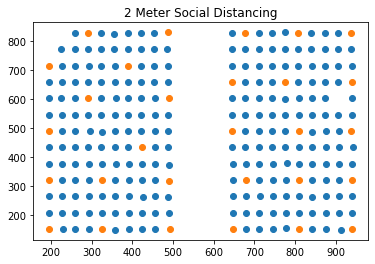

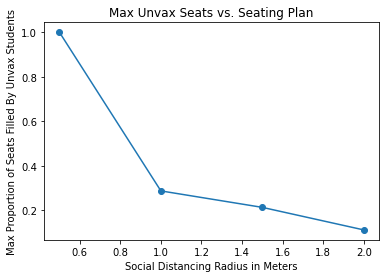

In [68]:
x_coord = [i.x for i in results_05_meter['Middles']]
y_coord = [i.y for i in results_05_meter['Middles']]

room05meter = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room05meter['UnvaxSpot'] = results_05_meter['In Solution']

room05meter = room05meter.groupby(['x','y']).sum()
room05meter = room05meter.reset_index()

x_coord = [i.x for i in results_1_meter['Middles']]
y_coord = [i.y for i in results_1_meter['Middles']]

room1meter = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room1meter['UnvaxSpot'] = results_1_meter['In Solution']

room1meter = room1meter.groupby(['x','y']).sum()
room1meter = room1meter.reset_index()

x_coord = [i.x for i in results_15_meter['Middles']]
y_coord = [i.y for i in results_15_meter['Middles']]

room15meter = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room15meter['UnvaxSpot'] = results_15_meter['In Solution']
room15meter = room15meter.groupby(['x','y']).sum()
room15meter = room15meter.reset_index()


x_coord = [i.x for i in results_2_meter['Middles']]
y_coord = [i.y for i in results_2_meter['Middles']]

room2meter = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room2meter['UnvaxSpot'] = results_2_meter['In Solution']
room2meter = room2meter.groupby(['x','y']).sum()
room2meter = room2meter.reset_index()

plt.figure()
plt.scatter(room05meter[room05meter['UnvaxSpot'] == 0]['x'],room05meter[room05meter['UnvaxSpot'] == 0]['y'])
plt.scatter(room05meter[room05meter['UnvaxSpot'] == 1]['x'],room05meter[room05meter['UnvaxSpot'] == 1]['y'])
plt.title('0.5 Meter Social Distancing')

plt.figure()
plt.scatter(room1meter[room1meter['UnvaxSpot'] == 0]['x'],room1meter[room1meter['UnvaxSpot'] == 0]['y'])
plt.scatter(room1meter[room1meter['UnvaxSpot'] == 1]['x'],room1meter[room1meter['UnvaxSpot'] == 1]['y'])
plt.title('1 Meter Social Distancing')

plt.figure()
plt.scatter(room15meter[room15meter['UnvaxSpot'] == 0]['x'],room15meter[room15meter['UnvaxSpot'] == 0]['y'])
plt.scatter(room15meter[room15meter['UnvaxSpot'] == 1]['x'],room15meter[room15meter['UnvaxSpot'] == 1]['y'])
plt.title('1.5 Meter Social Distancing')

plt.figure()
plt.scatter(room2meter[room2meter['UnvaxSpot'] == 0]['x'],room2meter[room2meter['UnvaxSpot'] == 0]['y'])
plt.scatter(room2meter[room2meter['UnvaxSpot'] == 1]['x'],room2meter[room2meter['UnvaxSpot'] == 1]['y'])
plt.title('2 Meter Social Distancing')

plt.figure()
spaces = [sum(room05meter['UnvaxSpot']),sum(room1meter['UnvaxSpot']),sum(room15meter['UnvaxSpot']),sum(room2meter['UnvaxSpot'])]
spaces = [x/257 for x in spaces]
plt.plot([0.5,1,1.5,2],spaces)
plt.scatter([0.5,1,1.5,2],spaces)
plt.xlabel('Social Distancing Radius in Meters')
plt.ylabel('Max Proportion of Seats Filled By Unvax Students')
plt.title('Max Unvax Seats vs. Seating Plan')

In [69]:
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Generate seating plan given a room, number of students, proportion of students vaccinated
"""
def generate_seating_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    grid = room.copy()
    grid = grid.reset_index()
    grid['seating'] = 'E'

    gridunvax = grid[grid['UnvaxSpot'] == 1]
    unvax_seats = list(gridunvax['index'].sample(Nunvax).values)
    grid['seating'].loc[grid['index'].isin(unvax_seats)] = 'U'
    
    vax_seats = random.sample(Diff(list(grid['index'].values),unvax_seats),Nvax)
    grid['seating'].loc[grid['index'].isin(vax_seats)] = 'V'
    
    return grid


"""
Arguments:
    Room: Room object generated from function above
    vax_infected: number of students in room vaccinated and infected
    unvax_infected: number of students if unvaccinated and infectied
    time: time of classroom
    function: function to return probability of infection for an uninfected student given 
                distance to other infected students and exposure time
    
    
Returns: Number of students infected

"""

def simulate_class(room,vax_infected, unvax_infected, time, function):
    
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]

    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        status = row['seating']

        distance_unvax_infected = ((infected[infected['seating'] == 'U']['x'] -
                     x) ** 2 + (infected[infected['seating'] == 'U']['y'] - y) ** 2) ** 0.5

        distance_vax_infected = ((infected[infected['seating'] == 'V']['x'] -
                     x) ** 2 + (infected[infected['seating'] == 'V']['y'] - y) ** 2) ** 0.5
        
        p = function(status, distance_unvax_infected,distance_vax_infected, time)
        p_infections.append(p)
     
    return np.sum(p_infections)



"""
Function that takes the distance to all infected unvaxinated students + exposure time
returns probability of infection

Assumptions: Vaccinated Students cannot contract or transmit the virus.

"""
def distance_to_prob_unvax_only(status,distance_unvax_infected,distance_vax_infected,time):
    distance_unvax_infected = distance_unvax_infected/conversion_pixel_ft*0.3048
    if status == 'V':
        alpha = 0
        
    elif status == 'U':
        alpha = 1
    
    gamma_mask = 0.1
    
    
    tot_prob = 0
    for dist in distance_unvax_infected:
        if dist > 1.1:
            prob = np.exp(-alpha*0.00268* (-0.1819*np.log(dist) +  0.4328) * gamma_mask * time)
            
        elif dist <= 0.5:
            prob = np.exp(-0.017*gamma_mask*time)
        
        elif dist > .5 and dist <= 1.1:
            prob = np.exp(-0.0079*gamma_mask*time)

        tot_prob = tot_prob + (1-prob)
    
    return tot_prob

"""
Distance to probability with various functions for if student is vaxinated or unvaxinated
"""
def distance_to_prob(status,distance_unvax_infected, distance_vax_infected ,time):
    distance_unvax_infected = distance_unvax_infected/conversion_pixel_ft*0.3048
    distance_vax_infected = distance_vax_infected/conversion_pixel_ft*0.3048
    
    if status == 'V':
        alpha = 0.25
        
    elif status == 'U':
        alpha = 1
    
    tot_prob = 0
    
    for dist in distance_unvax_infected:
        prob = 0.99907*dist**0.00039
        tot_prob = tot_prob + max((1-prob),0)
        
    for dist in distance_vax_infected:
        prob = 0.999977*dist**0.000097
        tot_prob = tot_prob + max((1-prob),0)
        
    return alpha*tot_prob

# Fill Rooms to Maximum Capacity and assess risk

In [70]:
room_list =  [room05meter,room1meter,room15meter,room2meter]
max_seating = []
for room in room_list:
    room = room.copy()
    room['seating'] = 'V'
    room['seating'].loc[room['UnvaxSpot'] == 1] = 'U'
    max_seating.append(room)

In [71]:
secondary_infections = []
for seated_room in max_seating:
    gc.collect()
    i = 0
    results = []
    while i < 100:
        rand = random.randint(1,5)
                    
        # ind = 1 vax infected, ind = 0 unvax infected
        if rand == 1:
            ind = 1
        if rand > 1:
            ind = 0
            
        if sum(seated_room['UnvaxSpot']) == len(seated_room):
            ind = 0
        infect = simulate_class(seated_room,ind, 1-ind, 1, distance_to_prob)
        results.append(infect)
        i = i+1
    temp = (np.mean(results))
    secondary_infections.append(temp)


Text(0.5, 1.0, 'Fully Occupied Classrooms')

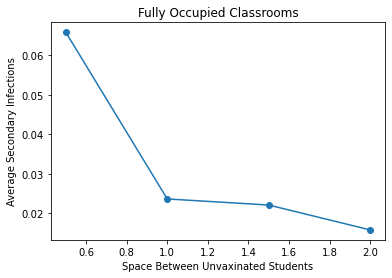

In [73]:
plt.plot([0.5,1,1.5,2],secondary_infections)
plt.scatter([0.5,1,1.5,2],secondary_infections)
plt.xlabel('Space Between Unvaxinated Students')
plt.ylabel('Average Secondary Infections')
plt.title('Fully Occupied Classrooms')

# use 

# Simulate Fall 2020

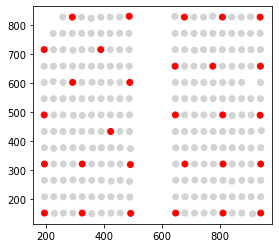

In [74]:
N = 29
p = 0

grid2020 = generate_seating_plan(N,p,room2meter)
plt.scatter(grid2020['x'],grid2020['y'], c = grid2020['seating'].replace({'U':'red', 'V':'blue','E':'lightgrey'}))
plt.gca().set_aspect('equal', adjustable='box')

In [75]:
grid2020

,index,x,y,UnvaxSpot,seating
0,0,194.231656,433.987945,0.0,E
1,1,194.231656,490.987945,1.0,U
2,2,194.231656,546.987945,0.0,E
3,3,194.231656,602.987945,0.0,E
4,4,194.231656,658.987945,0.0,E
...,...,...,...,...,...
251,251,940.231656,208.987945,0.0,E
252,252,940.231656,265.987945,0.0,E
253,253,940.231656,321.987945,1.0,U
254,254,940.231656,377.987945,0.0,E


In [76]:
gc.collect()
i = 0
results = []
while i < 100:
    infect = simulate_class(grid2020,0, 1, 1, distance_to_prob_unvax_only)
    results.append(infect)
    i = i+1
Fall2020_risk = (np.mean(results)*1/1000)
print('Fall2020Risk: ' + str(Fall2020_risk))

Fall2020Risk: 6.502461840803342e-07


# Contour Plots across various R

In [77]:
N_range = np.arange(29,257,8)
p_range = np.arange(0,1.1,.1)
room_list =  [room05meter,room1meter,room15meter,room2meter]
results = []

for N in N_range:
    for p in p_range:
        print(N,p)
        for room in room_list:
            try:
                trial = 0
                while trial < 100:
                    grid = generate_seating_plan(N,p,room)
                    rand = random.randint(1,5)
                    
                    # ind = 1 vax infected, ind = 0 unvax infected
                    
                    if rand == 1:
                        ind = 1
                    if rand > 1:
                        ind = 0
                    
                    if sum(room['UnvaxSpot']) == len(room):
                        ind = 0    
                    elif sum(grid['seating'] == 'V') == 0:
                        ind = 0
                    elif sum(grid['seating'] == 'U') == 0:
                        ind = 1
                
                        
                    
                    infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
                    number_unvax = sum(grid['seating']=='U')
                    results.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind ])
                    trial = trial + 1
            except:
                print('error')
            
results = pd.DataFrame(results,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind'])

29 0.0
29 0.1
29 0.2
29 0.30000000000000004
29 0.4
29 0.5
29 0.6000000000000001
29 0.7000000000000001
29 0.8
29 0.9
29 1.0
error
37 0.0
error
37 0.1
error
37 0.2
error
37 0.30000000000000004
37 0.4
37 0.5
37 0.6000000000000001
37 0.7000000000000001
37 0.8
37 0.9
37 1.0
error
45 0.0
error
45 0.1
error
45 0.2
error
45 0.30000000000000004
error
45 0.4
45 0.5
45 0.6000000000000001
45 0.7000000000000001
45 0.8
45 0.9
45 1.0
error
53 0.0
error
53 0.1
error
53 0.2
error
53 0.30000000000000004
error
53 0.4
error
53 0.5
53 0.6000000000000001
53 0.7000000000000001
53 0.8
53 0.9
53 1.0
error
61 0.0
error
error
61 0.1
error
61 0.2
error
61 0.30000000000000004
error
61 0.4
error
61 0.5
error
61 0.6000000000000001
61 0.7000000000000001
61 0.8
61 0.9
61 1.0
error
69 0.0
error
error
69 0.1
error
error
69 0.2
error
69 0.30000000000000004
error
69 0.4
error
69 0.5
error
69 0.6000000000000001
69 0.7000000000000001
69 0.8
69 0.9
69 1.0
error
77 0.0
error
error
error
77 0.1
error
error
77 0.2
error
error
7

In [82]:
results

,N,p,infected,number_unvax,number_unvax_seats,ind,p_max,Percent Occupancy,Percent Vaccinated
0,29,0.0,0.010750,29,257.0,0,0.000060,0.112840,0.0
1,29,0.0,0.008300,29,257.0,0,0.000078,0.112840,0.0
2,29,0.0,0.008393,29,257.0,0,0.000077,0.112840,0.0
3,29,0.0,0.009251,29,257.0,0,0.000070,0.112840,0.0
4,29,0.0,0.008119,29,257.0,0,0.000080,0.112840,0.0
...,...,...,...,...,...,...,...,...,...
74595,253,1.0,0.000063,0,29.0,1,0.010323,0.984436,1.0
74596,253,1.0,0.000064,0,29.0,1,0.010158,0.984436,1.0
74597,253,1.0,0.000082,0,29.0,1,0.007897,0.984436,1.0
74598,253,1.0,0.000029,0,29.0,1,0.022696,0.984436,1.0


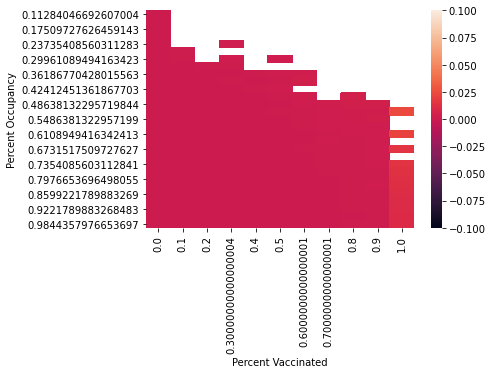

In [83]:
results['p_max']= [Fall2020_risk/x for x in results['infected'].values]
results['Percent Occupancy'] = results['N']/257
results['Percent Vaccinated'] = results['p']
agg_results = results.groupby(['Percent Occupancy','Percent Vaccinated']).p_max.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','p_max'))

(array([6.9791e+04, 1.9230e+03, 7.1300e+02, 3.9500e+02, 2.2000e+01,
        5.8400e+02, 1.9100e+02, 1.6000e+01, 0.0000e+00, 3.0000e+00]),
 array([7.85711004e-06, 2.63864923e-02, 5.27651275e-02, 7.91437627e-02,
        1.05522398e-01, 1.31901033e-01, 1.58279668e-01, 1.84658303e-01,
        2.11036939e-01, 2.37415574e-01, 2.63794209e-01]),
 <a list of 10 Patch objects>)

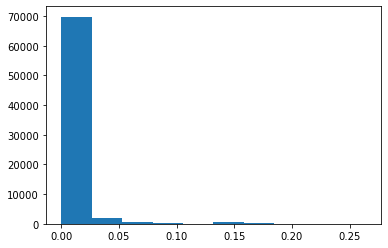

In [84]:
plt.hist(results[results['p_max']<1]['p_max'])

In [88]:
to_plot['number_unvax_seats'].unique()

array([257.,  74.,  55.,  29.])

In [101]:
p1 = to_plot[to_plot['number_unvax_seats'] == 29]
p2 = to_plot[to_plot['number_unvax_seats'] == 55]
p3 = to_plot[to_plot['number_unvax_seats'] == 74]
p4 = to_plot[to_plot['number_unvax_seats'] == 257]

Text(0.5, 1.0, '2 Meter Social Distancing')

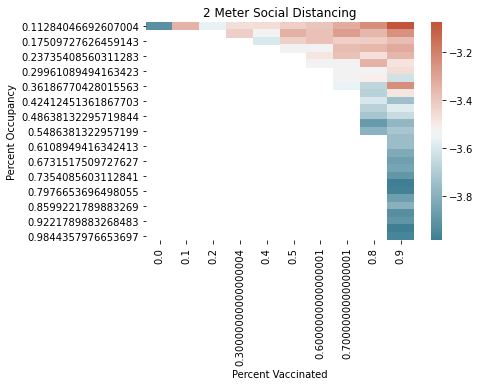

In [120]:
# R = 2
p1 = p1[p1['Percent Vaccinated'] < 1]
p1['lnpmax'] = np.log10(p1['p_max'])
agg_results = p1.groupby(['Percent Occupancy','Percent Vaccinated']).lnpmax.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','lnpmax'), cmap=cmap)
plt.title('2 Meter Social Distancing')

Text(0.5, 1.0, '1.5 Meter Social Distancing')

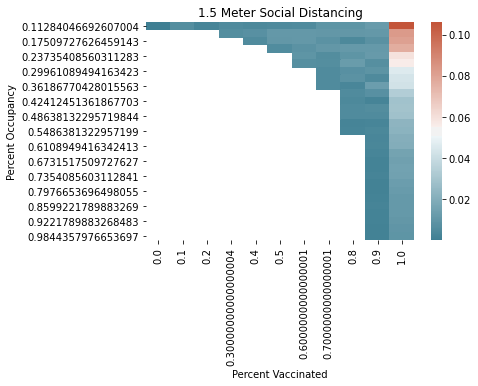

In [116]:
# R = 1.5
agg_results = p1.groupby(['Percent Occupancy','Percent Vaccinated']).p_max.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','p_max'),cmap=cmap)
plt.title('1.5 Meter Social Distancing')

Text(0.5, 1.0, '1 Meter Social Distancing')

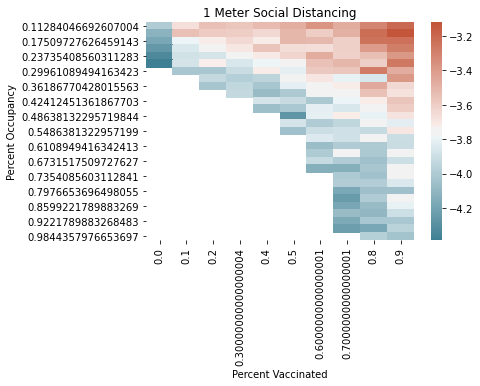

In [118]:
# R = 1
cmap = sns.diverging_palette(220, 20, as_cmap=True)
p3['lnpmax'] = np.log10(p3['p_max'])
agg_results = p3.groupby(['Percent Occupancy','Percent Vaccinated']).lnpmax.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','lnpmax'), cmap=cmap)
plt.title('1 Meter Social Distancing')

Text(0.5, 1.0, '0.5 Meter Social Distancing')

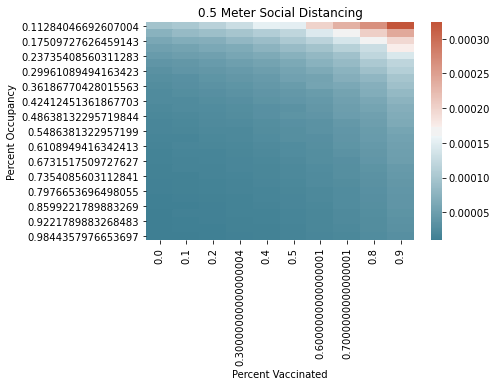

In [108]:
# R = 0.5
agg_results = p4.groupby(['Percent Occupancy','Percent Vaccinated']).p_max.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','p_max'), cmap=cmap)
plt.title('0.5 Meter Social Distancing')

Text(0.5, 1.0, 'Max Outside Prevelance Across All Configurations')

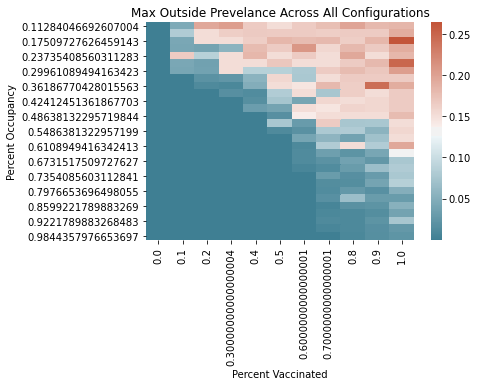

In [111]:
agg_results = to_plot.groupby(['Percent Occupancy','Percent Vaccinated']).p_max.max().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','p_max'), cmap=cmap)
plt.title('Max Outside Prevelance Across All Configurations')

In [19]:
N = 37
p = .2
room = room2meter
grid = generate_seating_plan(N,p,room)
ind = random.randint(0,1)
if sum(room['UnvaxSpot']) == len(room):
    ind = 0    
elif sum(grid['seating'] == 'V') == 0:
    ind = 0
elif sum(grid['seating'] == 'U') == 0:
    ind = 1

infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
number_unvax = sum(grid['seating']=='U')
[N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind ]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [16]:
sum(grid['seating'] == 'V')

0

# Simulate Fall 2021

In [ ]:
print('Max Seats: ' + str(len(room2021)))
print('Max Unvax Seat: '+ str(sum(room2021['UnvaxSpot'])))

In [ ]:
N_range = [50,200]
p_range = [0.65,0.9]
room_list =  [room05meter,room1meter,room15meter,room2meter]
results = []
for N in N_range:
    for p in p_range:
        for room in room_list:
            try:
                trial = 0
                while trial < 2:
                    grid = generate_seating_plan(N,p,room)
                    ind = random.randint(0,1)
                    if sum(room['UnvaxSpot']) == len(room):
                        ind = 0
                    infect = simulate_class(grid,ind, 1-ind,1,distance_to_prob)
                    number_unvax = sum(grid['seating']=='U')
                    results.append([N,p,infect,number_unvax,sum(room['UnvaxSpot']),ind ])
                    trial = trial + 1
                print('success')
            except:
                print('error')
            
results = pd.DataFrame(results,columns = ['N','p','infected','number_unvax','number_unvax_seats','ind'])

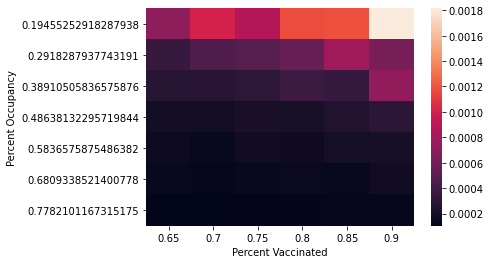

In [213]:
results['p_max'] = Fall2020_risk/results['infected']
results['Percent Occupancy'] = results['N']/257
results['Percent Vaccinated'] = results['p']
agg_results = results.groupby(['Percent Occupancy','Percent Vaccinated']).p_max.mean().reset_index()
sns.heatmap(agg_results.pivot('Percent Occupancy','Percent Vaccinated','p_max'))

In [214]:
29/257

0.11284046692607004

In [ ]:
# Plot x axis gap, y axis # of unvax seats